# Toxicology Testing
For this assignment, you will use a chemical dataset to train a neural network to predict human reaction to exposure to certain compounds.

# Import Packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deepchem as dc
from sklearn.metrics import accuracy_score
from tensorflow import keras
from keras import layers
import datetime

2024-10-05 21:46:41.629179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 21:46:42.312498: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-10-05 21:46:42.312580: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-10-05 21:46:42.312584: W tensorfl

# Set Environment

In [2]:
np.random.seed(456)
tf.random.set_seed(456)
# Only run this line if not yet loaded
%load_ext tensorboard

# Load and Prep Data

In [3]:
_, (train, valid, test), _ = dc.molnet.load_tox21()
train_X, train_y, train_w = train.X, train.y, train.w
valid_X, valid_y, valid_w = valid.X, valid.y, valid.w
test_X, test_y, test_w = test.X, test.y, test.w
train_y = train_y[:, 0]
valid_y = valid_y[:, 0]
test_y = test_y[:, 0]
train_w = train_w[:, 0]
valid_w = valid_w[:, 0]
test_w = test_w[:, 0]

# Significant Modification
Code originally written for Tensorflow v1, which has been deprecated for years. For this assignment, we will use Tensorflow v2. Re-writing the entire architecture, paying attention to the steps in the assignment, rather than the starter code. Will also be using Keras sequential architectures. One hint comes from [here](https://www.geeksforgeeks.org/hidden-layer-perceptron-in-tensorflow/).

# Define Model Placeholders

In [4]:
d = 1024
n_hidden = 50
learning_rate = .001
n_epochs = 10
batch_size = 100

# Create Model Architecture

In [5]:
model = keras.Sequential([ 
	layers.Dense(256, activation = 'relu', input_shape = [d]), 
	layers.BatchNormalization(), 
	layers.Dense(256, activation = 'relu'), 
	layers.Dropout(0.3), 
	layers.BatchNormalization(), 
	layers.Dense(1, activation = 'sigmoid') 
]) 

model.compile( 
	loss = 'KLD', 
	optimizer = 'adam', 
	metrics = ['AUC'] 
) 

model.summary()

2024-10-05 21:46:44.876770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                       

# Tensorboard Setup

In [6]:
# # https://www.tensorflow.org/tensorboard/get_started
# # Clear any logs from previous runs
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir = log_dir)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

# # Set up logging.
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = 'logs/func/%s' % stamp
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.
# z = model.fit(train_X, train_y, 
#           epochs = n_epochs, 
#           batch_size = batch_size, 
#           verbose = 1, 
#           validation_data = (valid_X, valid_y)) 
# with writer.as_default():
#   tf.summary.trace_export(
#       name="my_func_trace",
#       step=0,
#       profiler_outdir=logdir)

# Implement Mini-Batch Training

In [7]:
model_run = model.fit(train_X, train_y, 
          epochs = n_epochs, 
          batch_size = batch_size, 
          verbose = 1, 
          validation_data = (valid_X, valid_y),
          callbacks = [tensorboard_callback]) 

Epoch 1/10
63/63 [==============================] - 3s 24ms/step - loss: 0.0236 - auc: 0.7091 - val_loss: 0.0093 - val_auc: 0.6991
Epoch 2/10
63/63 [==============================] - 1s 17ms/step - loss: 0.0017 - auc: 0.9268 - val_loss: 0.0064 - val_auc: 0.7571
Epoch 3/10
63/63 [==============================] - 1s 16ms/step - loss: 2.1477e-04 - auc: 0.9717 - val_loss: 0.0054 - val_auc: 0.7843
Epoch 4/10
63/63 [==============================] - 1s 16ms/step - loss: 1.4732e-04 - auc: 0.9737 - val_loss: 0.0047 - val_auc: 0.7957
Epoch 5/10
63/63 [==============================] - 1s 15ms/step - loss: 9.4322e-05 - auc: 0.9749 - val_loss: 0.0043 - val_auc: 0.8009
Epoch 6/10
63/63 [==============================] - 1s 16ms/step - loss: 6.3519e-05 - auc: 0.9773 - val_loss: 0.0042 - val_auc: 0.8040
Epoch 7/10
63/63 [==============================] - 1s 16ms/step - loss: 6.7401e-05 - auc: 0.9748 - val_loss: 0.0045 - val_auc: 0.8090
Epoch 8/10
63/63 [==============================] - 1s 16ms/ste

# TensorBoard Results

In [8]:
%tensorboard --logdir logs

Launching TensorBoard...

# Plot Model Loss Curve

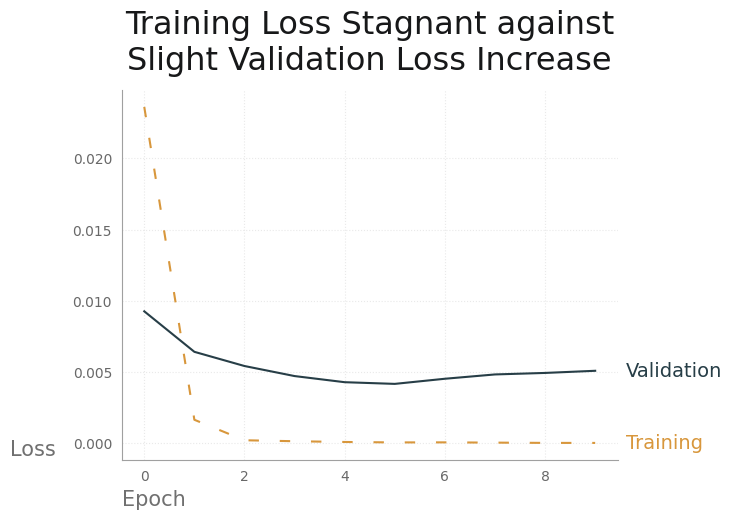

In [9]:
fig, ax = plt.subplots()
plt.grid(which = 'major', axis = 'both', linestyle = ':', color = '#e9e9e9')
plt.plot(range(0,10), model_run.history['loss'], color = '#D8973C', linestyle = (0, (5, 10)))
plt.plot(range(0,10), model_run.history['val_loss'], color = '#273E47')
ax.set_xlabel('Epoch', fontsize = 15, 
			  loc = 'left').set_color('#707070')
ax.set_ylabel('Loss', fontsize = 15, rotation = 'horizontal',
			  loc = 'bottom', labelpad = 45).set_color('#707070')
ax.set_title('Training Loss Stagnant against\nSlight Validation Loss Increase', fontsize = 23, pad = 15).set_color('#171819')
for pos in ['right', 'top']:
	plt.gca().spines[pos].set_visible(False)
ax.spines['bottom'].set_color('#A0A0A0')
ax.spines['left'].set_color('#A0A0A0')
ax.tick_params(axis='y', which='both', right=False,
			   left=False, colors = '#686868')
ax.tick_params(axis='x', which='both', top=False,
			   bottom=False, colors = '#686868')

for line, name in zip(ax.lines, ['Training', 'Validation']):
    y = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,y), xytext=(6,0), color = line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords = "offset points",
                size = 14, va = "center")

plt.show();

# Plot Model AUC

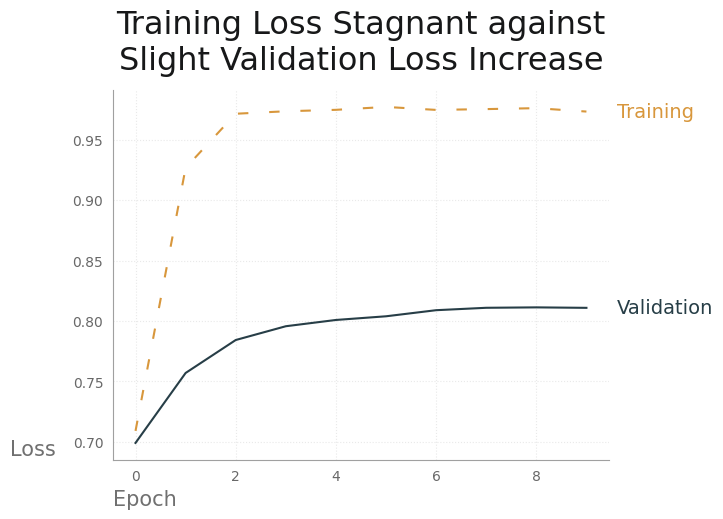

In [10]:
fig, ax = plt.subplots()
plt.grid(which = 'major', axis = 'both', linestyle = ':', color = '#e9e9e9')
plt.plot(range(0,10), model_run.history['auc'], color = '#D8973C', linestyle = (0, (5, 10)))
plt.plot(range(0,10), model_run.history['val_auc'], color = '#273E47')
# ax.set_xlim([-3, 1000])
# ax.set_ylim([0, 10])
ax.set_xlabel('Epoch', fontsize = 15, 
			  loc = 'left').set_color('#707070')
ax.set_ylabel('Loss', fontsize = 15, rotation = 'horizontal',
			  loc = 'bottom', labelpad = 45).set_color('#707070')
ax.set_title('Validation AUC around 80% after 5 ', fontsize = 23, pad = 15).set_color('#171819')
for pos in ['right', 'top']:
	plt.gca().spines[pos].set_visible(False)
ax.spines['bottom'].set_color('#A0A0A0')
ax.spines['left'].set_color('#A0A0A0')
ax.tick_params(axis='y', which='both', right=False,
			   left=False, colors = '#686868')
ax.tick_params(axis='x', which='both', top=False,
			   bottom=False, colors = '#686868')

for line, name in zip(ax.lines, ['Training', 'Validation']):
    y = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,y), xytext=(6,0), color = line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords = "offset points",
                size = 14, va = "center")

plt.show();

In [11]:
model_run.history

{'loss': [0.023620115593075752,
  0.001653872663155198,
  0.00021476672554854304,
  0.00014731530973222107,
  9.432189835933968e-05,
  6.351939373416826e-05,
  6.740111712133512e-05,
  4.877726678387262e-05,
  3.0044460800127126e-05,
  2.8215608836035244e-05],
 'auc': [0.709096372127533,
  0.9268344640731812,
  0.9716646671295166,
  0.9737104177474976,
  0.9749059677124023,
  0.9773107767105103,
  0.9748450517654419,
  0.9755095839500427,
  0.9762871265411377,
  0.9734745025634766],
 'val_loss': [0.00926869735121727,
  0.006424698047339916,
  0.005428334232419729,
  0.004722422454506159,
  0.004291759338229895,
  0.004173545632511377,
  0.004533463157713413,
  0.00483669200912118,
  0.00494218897074461,
  0.005092981271445751],
 'val_auc': [0.6991463899612427,
  0.7570564150810242,
  0.7843385338783264,
  0.7957490086555481,
  0.8009393811225891,
  0.803985059261322,
  0.8090254068374634,
  0.811020016670227,
  0.8113632202148438,
  0.8109772205352783]}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c4d82d2-b129-4486-baa4-05c502f179ef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>